## 1. Import Libraries

In [6]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import matplotlib.pyplot as plt
import networkx as nx


# Step 1: Load Movie Ratings Data


In [ ]:
df = pd.read_csv("ratings.dat", sep="::", engine='python', names=["user", "item", "rating", "timestamp"])


- Loads user-movie ratings from a file (ratings.dat)
- Columns: user `(user ID)`, item `(movie ID)`, rating `(score 1-5)`, timestamp

# Step 2: Filter strong interactions (optional: only ratings >= 4)


In [ ]:
df = df[df['rating'] >= 4]

- Keeps only high ratings `(>= 4)` to focus on positive user-movie interactions

# Step 3: Build Triplets (user-item interaction as edges)


In [ ]:
triplets = []
for _, row in df.iterrows():
    user_node = f'u{row["user"]}'
    item_node = f'i{row["item"]}'
    triplets.append((user_node, 'interacts', item_node))


- Creates relationships like  ``(user1, interacts, movie2)`` for graph edges
- `u` prefix for users, `i` prefix for items (to distinguish node types)

# Step 4: Map entities to unique integer IDs


In [ ]:
entity2id = {}
def get_id(entity):
    if entity not in entity2id:
        entity2id[entity] = len(entity2id)
    return entity2id[entity]

- Assigns unique numbers to every user/movie (e.g., `u1` → 0, `i2` → 1)

# Step 5: Convert triplets into edge_index format for PyG


In [ ]:
edge_index = [[], []]
for h, r, t in triplets:
    h_id = get_id(h)
    t_id = get_id(t)
    edge_index[0].append(h_id)
    edge_index[1].append(t_id)

edge_index = torch.tensor(edge_index, dtype=torch.long)
x = torch.arange(len(entity2id), dtype=torch.long)
data = Data(x=x, edge_index=edge_index)


- Converts relationships into graph edges **(edge_index)**
- **Data** is a PyG object to store graph structure (nodes + edges)

# Step 6: Define the KGAT model


In [ ]:
class KGAT(nn.Module):
    def __init__(self, num_nodes, embedding_dim, num_heads=2):
        super(KGAT, self).__init__()
        self.embedding = nn.Embedding(num_nodes, embedding_dim)
        self.gat = GATConv(embedding_dim, embedding_dim, heads=num_heads, concat=False)
    
    def forward(self, x, edge_index):
        x = self.embedding(x)
        x = self.gat(x, edge_index)
        return x


- **KGAT** = Knowledge Graph Attention Network
- **Embedding** : Converts user/item IDs into numerical vectors
- **GATConv** : Graph Attention layer to learn relationships between nodes

# Step 7: Train the model


In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = KGAT(num_nodes=len(entity2id), embedding_dim=64).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

for epoch in range(30):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = -torch.mean(out)  # Placeholder loss — replace with BPR/CrossEntropy later
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: -0.0014
Epoch 5, Loss: -0.1533
Epoch 10, Loss: -0.4067
Epoch 15, Loss: -0.7449
Epoch 20, Loss: -1.1677
Epoch 25, Loss: -1.6807


- An **epoch** is one complete pass through the entire training dataset during the training of a machine learning model.
- **Loss** measures how well the model is performing. `Lower loss values` indicate better alignment between predicted and actual outputs.

- Trains the model to learn user/item representations
- Uses a placeholder loss (would normally use ranking loss like BPR)


# Step 8: Recommend top-N items for a given user


In [ ]:
def recommend_top_k(user_id_str, top_k=5):
    model.eval()
    if user_id_str not in entity2id:
        print(f"User {user_id_str} not found.")
        return

    user_node_id = entity2id[user_id_str]
    user_embedding = model.embedding.weight[user_node_id]
    item_scores = []

    for entity, idx in entity2id.items():
        if entity.startswith('i'):  # item nodes only
            item_embedding = model.embedding.weight[idx]
            score = torch.dot(user_embedding, item_embedding).item()
            item_scores.append((entity, score))

    top_items = sorted(item_scores, key=lambda x: -x[1])[:top_k]
    print(f"\nTop {top_k} Recommendations for {user_id_str}:")
    for item, score in top_items:
        print(f"{item} (score: {score:.4f})")

# Recommend items for user ID 1
recommend_top_k('u1')



Top 5 Recommendations for u1:
i424 (score: 33.1340)
i2306 (score: 28.2623)
i3641 (score: 28.1047)
i156 (score: 26.7085)
i2678 (score: 26.4500)


# Step 9: Visualize knowledge graph neighborhood of a user


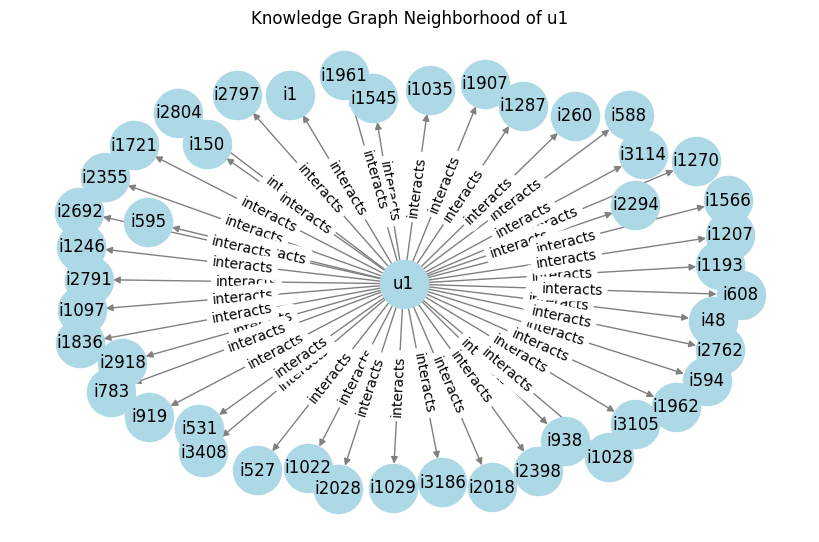

In [ ]:

def visualize_user_graph(user_id_str):
    G = nx.DiGraph()
    for h, r, t in triplets:
        if h == user_id_str:
            G.add_edge(h, t, label=r)
    
    if len(G.edges) == 0:
        print(f"No interactions found for user {user_id_str}")
        return

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 5))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=1200)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(h, t): r for h, r, t in triplets if h == user_id_str})
    plt.title(f"Knowledge Graph Neighborhood of {user_id_str}")
    plt.show()

# Visualize user u1's interactions
visualize_user_graph('u1')


 
# Summery 

This project builds a basic `Knowledge Graph Attention Network (KGAT)` using your own ratings.dat dataset, where users rate items (e.g., movies). It first transforms the dataset into a graph structure, with nodes representing users and items, and edges representing interactions. Each node is assigned an embedding, and the model uses graph attention to learn which neighbors (e.g., which items a user interacted with) are most influential. The **KGAT model** is trained with a simple placeholder loss to demonstrate the pipeline. After training, the model recommends the `top-N` items for a sample user by comparing the user's embedding with item embeddings. **Finally**, it visualizes a user's neighborhood in the knowledge graph to show which items they interacted with and how the graph is structured.

# Conclusion

This project successfully demonstrates how a **Knowledge Graph Attention Network (KGAT)** can be applied to a real-world recommendation task using custom interaction data. By representing users and items as nodes in a graph and applying attention-based message passing, the model learns to prioritize meaningful connections for generating personalized recommendations. The `final output` includes top-N item suggestions for users and a visual understanding of user-item relationships within the knowledge graph. 